from susie results, what fraction of lead vars are shared with gene within 1MB?

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm.notebook import tqdm
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker


In [2]:
# Load in tissue colors 
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json') as f:
    tissue_df = pd.DataFrame.from_dict(json.load(f), orient='index')
tissue_df = tissue_df.reset_index(names='tissue_name')
tissue_df['tissue_color_hex'] = '#' + tissue_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_df['tissue_color_hex'])

# get the versions of tissue ids in file names
tissue_df['tissue_file_name'] = (
    tissue_df['tissue_name']
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace(' - ', '_')
    .str.replace(' ', '_')
)

gene_type_pal= {'lncRNA':'#b70657',
                            'sRNA':'#2D716F',
                            'pseudogene':'#734675',
                            'protein_coding':'#016895', 
                            'artifact':'grey'}

                            
gene_type_order_highlight = ['new_lncRNA', 'existing_lncRNA', 'protein_coding', 'pseudogene', 'sRNA']

# Use a lighter/greyer version for all except new_lncRNA
gene_type_pal_greyed = {
    'new_lncRNA': '#b70657',         
    'existing_lncRNA': '#d6a5b7',    
    'sRNA': '#b3c6c6',           # lighter/greyer teal
    'pseudogene': '#c2b0c6',     # lighter/greyer purple
    'protein_coding': '#a3b9c6', # lighter/greyer blue
    'artifact': '#cccccc'}        # light grey


tissue_color_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_color_hex']))

In [3]:
tissue_df.head()

,tissue_name,tissue_abbrv,tissue_color_hex,tissue_color_rgb,tissue_file_name
0,Adipose - Subcutaneous,ADPSBQ,#FFA54F,"255,165,79",Adipose_Subcutaneous
1,Adipose - Visceral (Omentum),ADPVSC,#EE9A00,"238,154,0",Adipose_Visceral_Omentum
2,Adrenal Gland,ADRNLG,#8FBC8F,"143,188,143",Adrenal_Gland
3,Artery - Aorta,ARTAORT,#8B1C62,"139,28,98",Artery_Aorta
4,Artery - Coronary,ARTCRN,#EE6A50,"238,106,80",Artery_Coronary


In [4]:
gencode_ids = pd.read_table('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching_lncrna_category.txt')
gencode_ids['gene_type_grouped'] = np.where(gencode_ids['gene_type_grouped_highlight'].str.contains('lncRNA'), 'lncRNA', gencode_ids['gene_type_grouped_highlight'])


/local/scratch/klawren/slrmtmp.48897955/ipykernel_33904/1828589607.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_table('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching_lncrna_category.txt')


In [5]:
def load_susie_df(tissue_df, gencode_ids, egene_results_dir, file_end):
    esusie = []
    esusie_tissues = []
    for _, row in tissue_df.iterrows():
        try:
            file_path = f"{egene_results_dir}/{row['tissue_file_name']}.{file_end}.SuSiE_summary.parquet"
            esusie.append(pd.read_parquet(file_path))
            esusie_tissues.append(row['tissue_file_name'])
        except Exception:
            print(f"No Susie results for {row['tissue_file_name']}")

    if not esusie:
        raise ValueError("No Susie files were loaded. Please check your input paths and tissue list.")

    esusie_df = pd.concat(esusie, keys=esusie_tissues, names=['tissue_id', 'idx']).reset_index(level=1, drop=True).reset_index()
    esusie_df['gene_id_stable'] = esusie_df['phenotype_id'].str.split('.').str[0].str.split(':').str[-1]
    esusie_df = pd.merge(
        esusie_df,
        gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight', 'lncrna_category']],
        on='gene_id_stable',
        how='left'
    )
    esusie_df.rename(columns={'gene_type_grouped_highlight': 'biotype', 'biotype': 'full_biotype'}, inplace=True)
    esusie_df['biotype'] = np.where(
        esusie_df['biotype'].str.contains('lncRNA', na=False),
        'lncRNA',
        esusie_df['biotype']
    )
    esusie_df['biotype'] = np.where(
        esusie_df['biotype'] == 'lncRNA',
        esusie_df['lncrna_category'] + '_lncRNA',
        esusie_df['biotype']
    )
    return esusie_df

In [6]:
v10_ssusie_df = load_susie_df(tissue_df, gencode_ids, "/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_v10_SuSiE_sQTL", file_end='v10.sQTLs')
v11_ssusie_df = load_susie_df(tissue_df, gencode_ids, "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_sQTL", file_end='v11.sQTLs')

No Susie results for Artery_Femoral
No Susie results for Cervix_Ectocervix
No Susie results for Cervix_Endocervix
No Susie results for Fallopian_Tube
No Susie results for Kidney_Medulla
No Susie results for Stomach_Mixed_Cell
No Susie results for Stomach_Mucosa
No Susie results for Stomach_Muscularis
No Susie results for Artery_Femoral
No Susie results for Cervix_Ectocervix
No Susie results for Cervix_Endocervix
No Susie results for Fallopian_Tube
No Susie results for Kidney_Medulla
No Susie results for Stomach_Mixed_Cell
No Susie results for Stomach_Mucosa
No Susie results for Stomach_Muscularis


In [ ]:
v10_essuie_df = load_susie_df(tissue_df, gencode_ids, "/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_v10_SuSiE_eQTL", file_end='v10.eQTLs')
v11_essuie_df = load_susie_df(tissue_df, gencode_ids, "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL", file_end='v11.eQTLs')

No Susie results for Artery_Femoral
No Susie results for Cervix_Ectocervix
No Susie results for Cervix_Endocervix
No Susie results for Fallopian_Tube
No Susie results for Kidney_Medulla
No Susie results for Stomach_Mixed_Cell
No Susie results for Stomach_Mucosa
No Susie results for Stomach_Muscularis
No Susie results for Artery_Femoral
No Susie results for Cervix_Ectocervix
No Susie results for Cervix_Endocervix
No Susie results for Fallopian_Tube
No Susie results for Kidney_Medulla
No Susie results for Stomach_Mixed_Cell
No Susie results for Stomach_Mucosa
No Susie results for Stomach_Muscularis


In [ ]:
v11_apassuie_df = load_susie_df(tissue_df, gencode_ids, "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_apaQTL", file_end='v11.apaQTLs')
v10_apassuie_df = load_susie_df(tissue_df, gencode_ids, "/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_v10_SuSiE_apaQTL", file_end='v10.apaQTLs')

No Susie results for Artery_Femoral
No Susie results for Cervix_Ectocervix
No Susie results for Cervix_Endocervix
No Susie results for Fallopian_Tube
No Susie results for Kidney_Medulla
No Susie results for Stomach_Mixed_Cell
No Susie results for Stomach_Mucosa
No Susie results for Stomach_Muscularis
No Susie results for Artery_Femoral
No Susie results for Cervix_Ectocervix
No Susie results for Cervix_Endocervix
No Susie results for Fallopian_Tube
No Susie results for Kidney_Medulla
No Susie results for Stomach_Mixed_Cell
No Susie results for Stomach_Mucosa
No Susie results for Stomach_Muscularis


In [17]:
new_lncrna_ids = gencode_ids[gencode_ids['gene_type_grouped_highlight']=='new_lncRNA']['gene_id_v47']

In [26]:
new_e_loci = v11_essuie_df[v11_essuie_df['phenotype_id'].isin(new_lncrna_ids)].drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id']).groupby('tissue_id').size()
new_s_loci = v11_ssusie_df[v11_ssusie_df['gene_id'].isin(new_lncrna_ids)].drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id']).groupby('tissue_id').size()
new_apa_loci = v11_apassuie_df[v11_apassuie_df['gene_id'].isin(new_lncrna_ids)].drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id']).groupby('tissue_id').size()
new_loci = pd.concat([new_e_loci, new_s_loci, new_apa_loci], keys=['eQTL', 'sQTL', 'apaQTL'], names=['qtl_type']).reset_index(name='independent loci')


Median number of independent loci for eQTL: 1119.0
Median number of independent loci for sQTL: 685.5
Median number of independent loci for apaQTL: 36.0


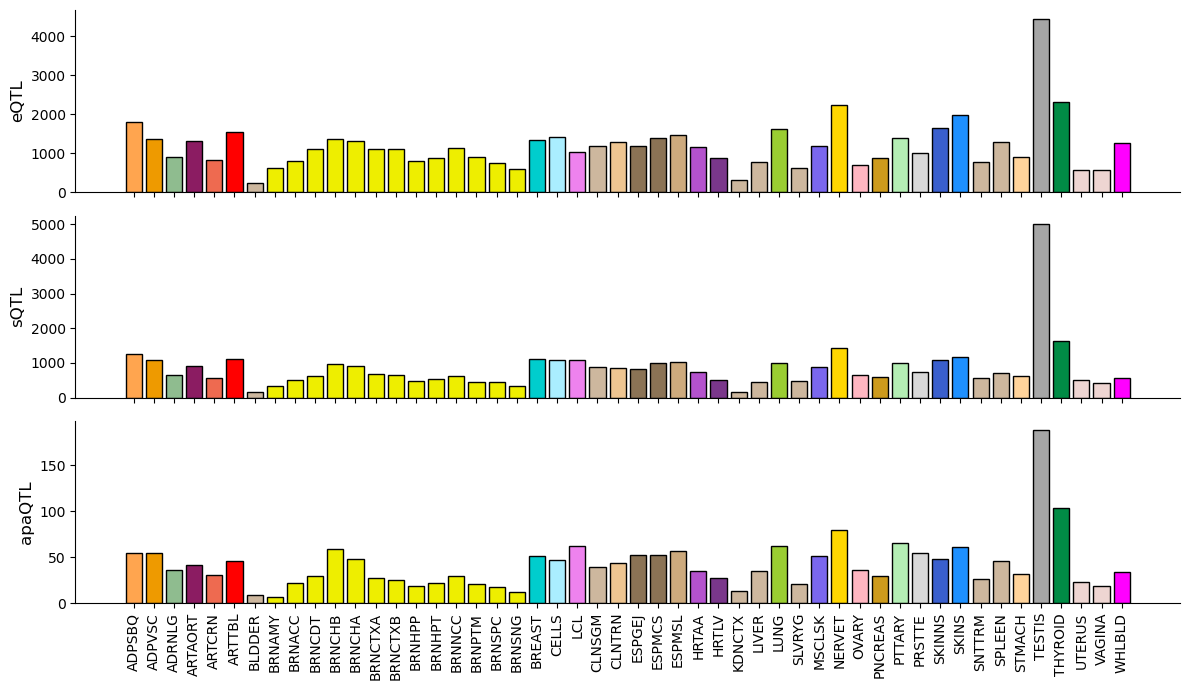

In [37]:

# Map tissue_id to tissue_abbrv and color
tissue_id_to_abbrv = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_abbrv']))
tissue_id_to_color = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_color_hex']))

# Pivot new_loci to have qtl_type as columns, tissue_id as index
pivot_loci = new_loci.pivot(index='tissue_id', columns='qtl_type', values='independent loci').fillna(0)

# Add tissue_abbrv and color columns for plotting
pivot_loci['tissue_abbrv'] = pivot_loci.index.map(tissue_id_to_abbrv)
pivot_loci['color'] = pivot_loci.index.map(tissue_id_to_color)

# Sort by total loci for better visualization
pivot_loci['total'] = pivot_loci[['eQTL', 'sQTL', 'apaQTL']].sum(axis=1)

# Set up three subplots with shared x-axis
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})

qtl_types = ['eQTL', 'sQTL', 'apaQTL']
dbar_width = 0.8
x = range(len(pivot_loci))

for i, (ax, qtl) in enumerate(zip(axes, qtl_types)):
    values = pivot_loci[qtl] if qtl in pivot_loci else 0
    bars = ax.bar(
        x,
        values,
        bar_width,
        color=pivot_loci['color'],
        edgecolor='black'
    )
    ax.set_ylabel(f'{qtl}', fontsize=12)
    # Despline top and right
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Optionally, add value labels on top of bars
    # for bar in bars:
    #     height = bar.get_height()
    #     if height > 0:
    #         ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
    #                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Set x-ticks and labels only on the bottom axis
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(pivot_loci['tissue_abbrv'], rotation=90)
# Print the median number of independent loci per tissue for each QTL type
for qtl in qtl_types:
    if qtl in pivot_loci:
        median_val = pivot_loci[qtl].median()
        print(f"Median number of independent loci for {qtl}: {median_val}")


plt.tight_layout()
plt.show()

In [ ]:
# Barplots: tissue_abbrv (y-axis) vs number of independent loci (x-axis) for new_esusie (left, mirrored) and new_ssusie (right), with a black line at the top of each bar for number of 1-variant credible sets per tissue

# Map tissue_id to tissue_abbrv using tissue_df
tissue_id_to_abbrv = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_abbrv']))

# Count unique phenotype_id/cs_id combos per tissue_id for new_esusie
unique_counts_esusie = (
    new_esusie
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id'])
    .groupby('tissue_id')
    .size()
    .reset_index(name='independent loci')
)
unique_counts_esusie['tissue_abbrv'] = unique_counts_esusie['tissue_id'].map(tissue_id_to_abbrv)

# Count unique phenotype_id/cs_id combos per tissue_id for new_ssusie
unique_counts_ssusie = (
    new_ssusie
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id'])
    .groupby('tissue_id')
    .size()
    .reset_index(name='independent loci')
)
unique_counts_ssusie['tissue_abbrv'] = unique_counts_ssusie['tissue_id'].map(tissue_id_to_abbrv)

# Count number of 1-variant credible sets per tissue for new_esusie
esusie_cs_counts = (
    new_esusie
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'])
    .size()
    .reset_index(name='variant_count')
)
esusie_1cs = esusie_cs_counts[esusie_cs_counts['variant_count'] == 1]
esusie_1cs_counts = (
    esusie_1cs
    .groupby('tissue_id')
    .size()
    .reset_index(name='1-variant loci')
)
esusie_1cs_counts['tissue_abbrv'] = esusie_1cs_counts['tissue_id'].map(tissue_id_to_abbrv)

# Count number of 1-variant credible sets per tissue for new_ssusie
ssusie_cs_counts = (
    new_ssusie
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'])
    .size()
    .reset_index(name='variant_count')
)
ssusie_1cs = ssusie_cs_counts[ssusie_cs_counts['variant_count'] == 1]
ssusie_1cs_counts = (
    ssusie_1cs
    .groupby('tissue_id')
    .size()
    .reset_index(name='1-variant loci')
)
ssusie_1cs_counts['tissue_abbrv'] = ssusie_1cs_counts['tissue_id'].map(tissue_id_to_abbrv)

# Merge for consistent y order
all_tissues = pd.DataFrame({'tissue_abbrv': sorted(set(unique_counts_esusie['tissue_abbrv']).union(set(unique_counts_ssusie['tissue_abbrv'])))})
unique_counts_esusie = all_tissues.merge(unique_counts_esusie, on='tissue_abbrv', how='left')
unique_counts_ssusie = all_tissues.merge(unique_counts_ssusie, on='tissue_abbrv', how='left')
esusie_1cs_counts = all_tissues.merge(esusie_1cs_counts, on='tissue_abbrv', how='left')
ssusie_1cs_counts = all_tissues.merge(ssusie_1cs_counts, on='tissue_abbrv', how='left')

# Set up the figure with 2 axes: left barplot and right barplot, no center label
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 4), dpi=150, sharey=True, gridspec_kw={'wspace': 0.02})
sns.set(style="whitegrid")

# Plot left (eQTL, mirrored)
sns.barplot(
    data=unique_counts_esusie,
    y='tissue_abbrv',
    x='independent loci',
    palette=tissue_color_map,
    hue='tissue_id',
    legend=False,
    ax=ax_left,
    dodge=False,
    width=1
)

# # Overlay a black line as a vertical line for 1-variant loci
# for idx, row in esusie_1cs_counts.iterrows():
#     y = row['tissue_abbrv']
#     x = row['1-variant loci']
#     if pd.notnull(x):
#         y_pos = list(all_tissues['tissue_abbrv']).index(y)
#         ax_left.vlines(
#             x=x, ymin=y_pos - 0.4, ymax=y_pos + 0.4, color='black', linewidth=2, zorder=10
#         )

ax_left.invert_xaxis()
ax_left.set_ylabel('')
ax_left.yaxis.set_ticks_position('none')
ax_left.set_xlabel('eQTL independent loci')
ax_left.spines['top'].set_visible(False)
ax_left.spines['right'].set_visible(False)
ax_left.spines['left'].set_visible(False)
ax_left.spines['bottom'].set_visible(True)
ax_left.grid(axis='x', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax_left.grid(axis='y', visible=False)
ax_left.tick_params(axis='y', left=False, labelleft=False)

# Remove zero from x-axis ticks on the left plot
x_ticks = ax_left.get_xticks()
x_ticks_nozero = [tick for tick in x_ticks if tick != 0]
ax_left.set_xticks(x_ticks_nozero)

# Plot right (sQTL)
sns.barplot(
    data=unique_counts_ssusie,
    y='tissue_abbrv',
    x='independent loci',
    palette=tissue_color_map,
    hue='tissue_id',
    legend=False,
    ax=ax_right,
    dodge=False,
    width=1
)

# # Overlay a black line as a vertical line for 1-variant loci
# for idx, row in ssusie_1cs_counts.iterrows():
#     y = row['tissue_abbrv']
#     x = row['1-variant loci']
#     if pd.notnull(x):
#         y_pos = list(all_tissues['tissue_abbrv']).index(y)
#         ax_right.vlines(
#             x=x, ymin=y_pos - 0.4, ymax=y_pos + 0.4, color='black', linewidth=2, zorder=10
#         )

ax_right.yaxis.set_ticks_position('none')
ax_right.set_ylabel('')
ax_right.set_xlabel('sQTL independent loci')
ax_right.spines['top'].set_visible(False)
ax_right.spines['right'].set_visible(False)
ax_right.spines['left'].set_visible(False)
ax_right.spines['bottom'].set_visible(True)
ax_right.grid(axis='x', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax_right.grid(axis='y', visible=False)
ax_right.tick_params(axis='y', left=False, labelleft=False)
print(ax_right.get_ylim())
ax_right.set_ylim(-1, 50)
ax_left.set_ylim(-1, 50)
plt.show()

,tissue_id,phenotype_id,gene_id,gene_name,full_biotype,variant_id,pip,af,cs_id,cs_size,gene_id_stable,biotype,lncrna_category
0,Adipose_Subcutaneous,ENSG00000225630.1_chr1:629640-630683,ENSG00000225630.1,MTND2P28,unprocessed_pseudogene,chr1_875397_C_G_b38,0.967832,0.018284,1,1,ENSG00000225630,pseudogene,NaN
1,Adipose_Subcutaneous,ENSG00000225880.7_chr1:825553-826770,ENSG00000225880.7,LINC00115,lncRNA,chr1_818025_C_A_b38,0.074824,0.829114,1,7,ENSG00000225880,sense_lncRNA,sense
2,Adipose_Subcutaneous,ENSG00000225880.7_chr1:825553-826770,ENSG00000225880.7,LINC00115,lncRNA,chr1_818045_T_C_b38,0.032993,0.828411,1,7,ENSG00000225880,sense_lncRNA,sense
3,Adipose_Subcutaneous,ENSG00000225880.7_chr1:825553-826770,ENSG00000225880.7,LINC00115,lncRNA,chr1_824457_T_A_b38,0.059323,0.829114,1,7,ENSG00000225880,sense_lncRNA,sense
4,Adipose_Subcutaneous,ENSG00000225880.7_chr1:825553-826770,ENSG00000225880.7,LINC00115,lncRNA,chr1_827209_G_C_b38,0.309394,0.830520,1,7,ENSG00000225880,sense_lncRNA,sense


In [ ]:
v11_apassuie_df.groupby('tissue_id')['cs_id'].nunique().sort_values(ascending=False)

In [ ]:
# Plot: Place eGene, sGene, and apaGene bars for v10 and v11 next to each other, add totals, and print % increase

# Expanded qtl_order to include 'apaGene'
expanded_qtl_order = ['eGene', 'sGene', 'apaGene']
gene_type_order = ['sRNA', 'pseudogene', 'protein_coding', 'existing_lncRNA', 'new_lncRNA']
version_order = ['v10', 'v11']

fig, ax = plt.subplots(figsize=(7, 4), dpi=600)

bar_width = 1
n_versions = len(version_order)
n_qtl_types = len(expanded_qtl_order)
n_groups = n_versions * n_qtl_types

# Arrange bars so that for each QTL type, v10 and v11 are adjacent
x = []
xticklabels = []
bar_positions = {}
for i, qtl_type in enumerate(expanded_qtl_order):
    for j, version in enumerate(version_order):
        xpos = i * (n_versions + 0.5) + j  # Add 0.5 for spacing between QTL types
        x.append(xpos)
        xticklabels.append(f"{version}")
        bar_positions[(qtl_type, version)] = xpos

# Plot stacked bars for each gene type and collect bar tops for annotation
bar_tops = {k: 0 for k in range(len(x))}
bar_handles = []

# To avoid KeyError for missing (qtl_type, version) in pivot, always use .get() with default 0
for idx, gene_type in enumerate(gene_type_order):
    bottoms = [0] * len(x)
    if idx > 0:
        for k, (qtl_type, version) in enumerate([(qt, v) for qt in expanded_qtl_order for v in version_order]):
            prev_sum = 0
            for m in range(idx):
                # Use .get() to avoid KeyError for missing (qtl_type, version)
                if (qtl_type, version) in pivot.index and gene_type_order[m] in pivot.columns:
                    prev_sum += pivot.loc[(qtl_type, version)].get(gene_type_order[m], 0)
                else:
                    prev_sum += 0
            bottoms[k] = prev_sum
    # If (qtl_type, version) not in pivot, fill with zeros
    heights = []
    for qtl_type in expanded_qtl_order:
        for version in version_order:
            if (qtl_type, version) in pivot.index and gene_type in pivot.columns:
                heights.append(pivot.loc[(qtl_type, version)].get(gene_type, 0))
            else:
                heights.append(0)
    bars = ax.bar(
        x,
        heights,
        bar_width,
        bottom=bottoms,
        color=gene_type_pal_greyed[gene_type],
        edgecolor='black',
        label=gene_type.replace('_', ' '),  # For legend
    )
    bar_handles.append(bars[0])
    for k, h in enumerate(heights):
        bar_tops[k] += h

# Annotate total number at the top of each bar
for k, xpos in enumerate(x):
    total = bar_tops[k]
    ax.text(
        xpos, 
        total + max(bar_tops) * 0.01,  # Small offset above bar
        f"{int(total):,}", 
        ha='center', va='bottom', fontsize=10,
    )

# Add legend for gene types to the right side, in reverse order
ax.legend(
    handles=bar_handles[::-1],
    labels=[gt.replace('_', ' ') for gt in gene_type_order[::-1]],
    title="Gene type",
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    borderaxespad=0,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
# Add horizontal lines for the total number of genes in v10 and v11 (non-NA gene_id_v47 and gene_id_v39)
total_genes_v11 = gencode_ids['gene_id_v47'].notna().sum()
total_genes_v10 = gencode_ids['gene_id_v39'].notna().sum()

# Draw horizontal lines across the plot for v10 and v11 totals
ax.axhline(total_genes_v10, color='grey', linestyle='--', linewidth=1)
ax.axhline(total_genes_v11, color='grey', linestyle='--', linewidth=1)

# Annotate the lines
ax.text(
    x[-1] + .7, total_genes_v10, 
    f"Total genes v10: {total_genes_v10:,}", 
    va='bottom', ha='right', color='grey', fontsize=9
)
ax.text(
    x[-1] + .7, total_genes_v11, 
    f"Total genes v11: {total_genes_v11:,}", 
    va='bottom', ha='right', color='grey', fontsize=9
)

# Set x-tick labels to just the versions (v10, v11) for each QTL type group
# and add a secondary label below, centered under each QTL type group

# Number of QTL types and versions
n_qtl = len(expanded_qtl_order)
n_ver = len(version_order)

# The x positions are ordered as: [eGene-v10, eGene-v11, sGene-v10, sGene-v11, apaGene-v10, apaGene-v11]
# So, for each QTL type, the two bars are at positions [i*2, i*2+1]
# We'll set the ticks at the center of each pair for the QTL type label, and at each bar for the version label

# Set version labels at each bar
version_labels = version_order * n_qtl  # ['v10', 'v11', 'v10', 'v11', ...]
ax.set_xticks(x)
ax.set_xticklabels(version_labels, fontsize=10)

# Add QTL type labels centered under each pair of bars
qtl_centers = [np.mean([x[i*n_ver], x[i*n_ver+1]]) for i in range(n_qtl)]
qtl_labels = []
for qtl_type in expanded_qtl_order:
    if qtl_type == 'eGene':
        qtl_labels.append('eGenes')
    elif qtl_type == 'sGene':
        qtl_labels.append('sGenes')
    elif qtl_type == 'apaGene':
        qtl_labels.append('apaGenes')
    else:
        qtl_labels.append(qtl_type)

# Draw the QTL type labels below the x-axis, centered under each pair
for xpos, label in zip(qtl_centers, qtl_labels):
    ax.text(
        xpos, 
        ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.15,  # a bit below the axis
        label, 
        ha='center', va='top', fontsize=11,
    )

# Adjust the bottom margin to make room for the extra label
plt.subplots_adjust(bottom=0.18)
ax.set_ylabel('Significant QTL in ≥1 tissue\n(FDR 5%)', labelpad=10)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{int(x):,}' if x == int(x) else f'{x:,.2f}'))
sns.despine(ax=ax)
plt.show()

# Print % increase in eGenes, sGenes, and apaGenes from v10 to v11
for qtl_type in expanded_qtl_order:
    if (qtl_type, 'v10') in pivot.index:
        n_v10 = pivot.loc[(qtl_type, 'v10')].sum()
    else:
        n_v10 = 0
    if (qtl_type, 'v11') in pivot.index:
        n_v11 = pivot.loc[(qtl_type, 'v11')].sum()
    else:
        n_v11 = 0
    if n_v10 > 0:
        pct_increase = 100 * (n_v11 - n_v10) / n_v10
        print(f"{qtl_type}: {n_v10:,} (v10) -> {n_v11:,} (v11), {pct_increase:+.1f}% change")
    else:
        print(f"{qtl_type}: {n_v10:,} (v10) -> {n_v11:,} (v11), n_v10 is zero, cannot compute % change")

In [ ]:
# Count number of unique tissue-phenotype-cs_id per biotype
num_unique_per_biotype = (
    v10_essuie_df
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id', 'biotype'])
    .groupby('biotype')
    .size()
    .rename('number of unique tissue-phenotype-cs per biotype')
)
num_unique_per_biotype

biotype
antisense_lncRNA                    53302
artifact                              570
intergenic_lncRNA                   47522
other_lncRNA                        14557
overlapping_both_strands_lncRNA      4155
protein_coding                     344307
pseudogene                          49561
sRNA                                  916
sense_lncRNA                         9651
Name: number of unique tissue-phenotype-cs per biotype, dtype: int64

In [ ]:
# Count number of unique tissue-phenotype-cs_id per biotype
num_unique_per_biotype = (
    v11_essuie_df
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id', 'biotype'])
    .groupby('biotype')
    .size()
    .rename('number of unique tissue-phenotype-cs per biotype')
)
num_unique_per_biotype

biotype
antisense_lncRNA                    76224
artifact                              559
intergenic_lncRNA                   87730
other_lncRNA                         5655
overlapping_both_strands_lncRNA      5272
protein_coding                     342944
pseudogene                          17422
sRNA                                  875
sense_lncRNA                        14891
Name: number of unique tissue-phenotype-cs per biotype, dtype: int64

In [ ]:
# Count number of unique tissue-phenotype-cs_id per biotype
num_unique_per_biotype = (
    v11_ssusie_df
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id', 'biotype'])
    .groupby('biotype')
    .size()
    .rename('number of unique tissue-phenotype-cs per biotype')
)
num_unique_per_biotype

biotype
antisense_lncRNA                    37775
artifact                               98
intergenic_lncRNA                   47570
overlapping_both_strands_lncRNA      7308
protein_coding                     459188
pseudogene                           6992
sense_lncRNA                        11283
Name: number of unique tissue-phenotype-cs per biotype, dtype: int64

In [ ]:
# Count number of unique tissue-phenotype-cs_id per biotype
num_unique_per_biotype = (
    v10_ssusie_df
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id', 'biotype'])
    .groupby('biotype')
    .size()
    .rename('number of unique tissue-phenotype-cs per biotype')
)
num_unique_per_biotype

biotype
antisense_lncRNA                    24801
artifact                              278
intergenic_lncRNA                   15043
other_lncRNA                         3807
overlapping_both_strands_lncRNA      5563
protein_coding                     458350
pseudogene                          45752
sense_lncRNA                         4526
Name: number of unique tissue-phenotype-cs per biotype, dtype: int64

In [ ]:
def get_tissue_gene_counts(df):
    # Count unique (phenotype_id, cs_id) per tissue
    return (
        df.groupby('tissue_id')
        .apply(lambda x: x.drop_duplicates(subset=['phenotype_id', 'cs_id']).shape[0])
        .rename('num_genes')
        .reset_index()
    )

# Get counts for each tissue and version
e_v10 = get_tissue_gene_counts(v10_essuie_df)
e_v10['qtl_type'] = 'eGene'
e_v10['version'] = 'v10'

e_v11 = get_tissue_gene_counts(v11_essuie_df)
e_v11['qtl_type'] = 'eGene'
e_v11['version'] = 'v11'

s_v10 = get_tissue_gene_counts(v10_ssusie_df)
s_v10['qtl_type'] = 'sGene'
s_v10['version'] = 'v10'

s_v11 = get_tissue_gene_counts(v11_ssusie_df)
s_v11['qtl_type'] = 'sGene'
s_v11['version'] = 'v11'

# Combine all into one DataFrame
cs_counts = pd.concat([e_v10, e_v11, s_v10, s_v11], ignore_index=True)

/local/scratch/klawren/slrmtmp.48894375/ipykernel_4394/3759096869.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop_duplicates(subset=['phenotype_id', 'cs_id']).shape[0])
/local/scratch/klawren/slrmtmp.48894375/ipykernel_4394/3759096869.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop_duplicates(subset=['phenotype_id', 'cs_id']).shape[0])
/local/scratch/klawren/slr

In [ ]:
pivot_df = cs_counts.pivot_table(
    index=['tissue_id', 'qtl_type'],
    columns='version',
    values='num_genes'
).reset_index()
pivot_df

version,tissue_id,qtl_type,v10,v11
0,Adipose_Subcutaneous,eGene,15960.0,16831.0
1,Adipose_Subcutaneous,sGene,18761.0,19075.0
2,Adipose_Visceral_Omentum,eGene,12530.0,13031.0
3,Adipose_Visceral_Omentum,sGene,14973.0,15279.0
4,Adrenal_Gland,eGene,8360.0,8676.0
...,...,...,...,...
95,Uterus,sGene,5586.0,5658.0
96,Vagina,eGene,4044.0,4249.0
97,Vagina,sGene,5162.0,5228.0
98,Whole_Blood,eGene,13200.0,13931.0


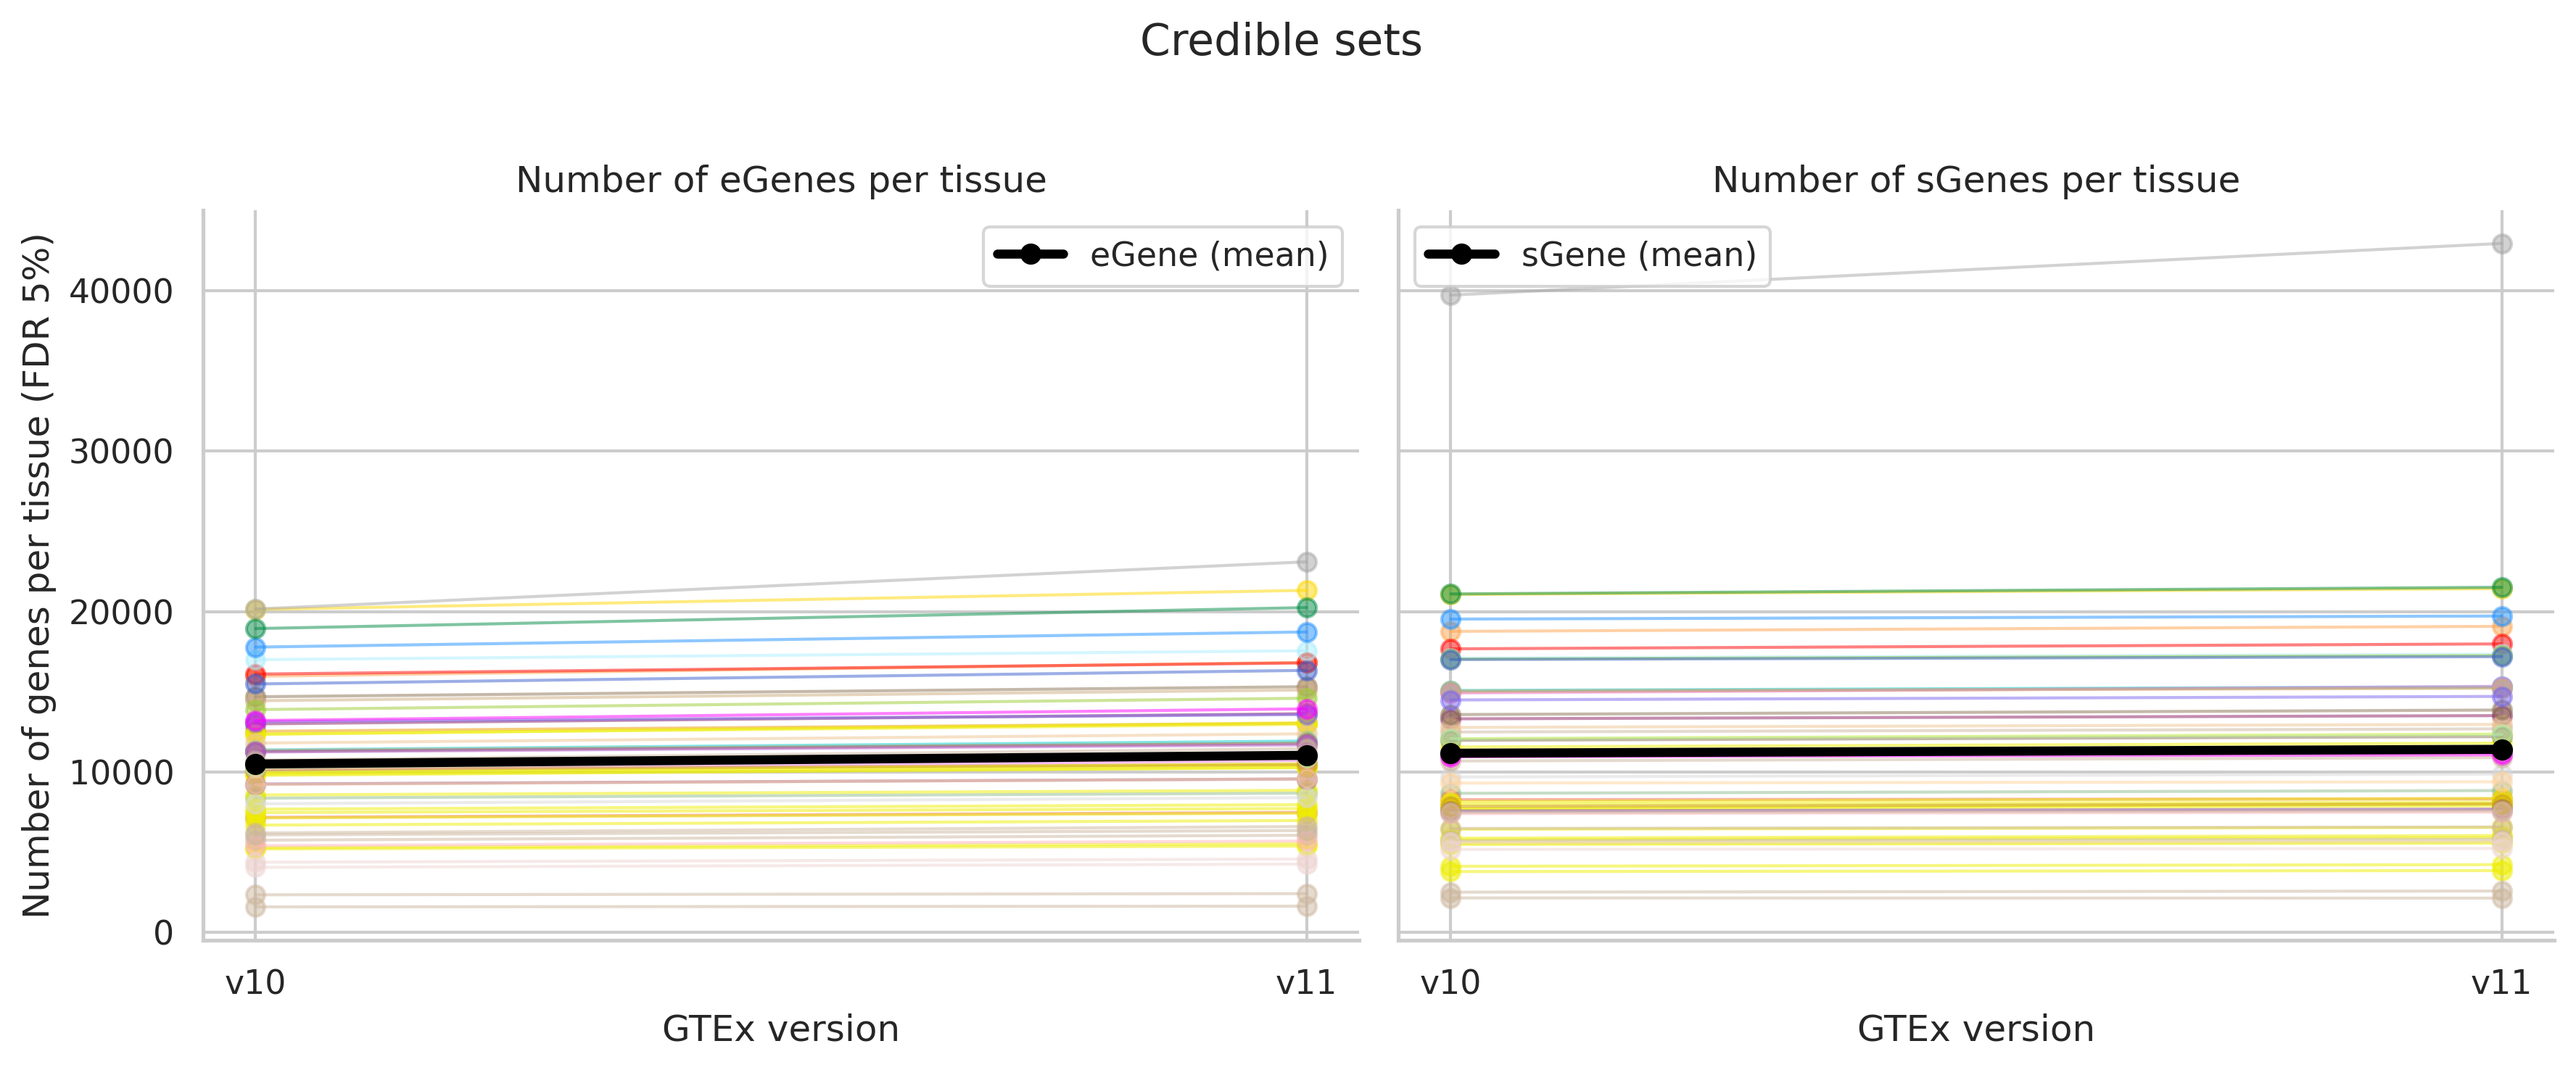

In [ ]:
# Plot per-tissue eGene and sGene counts for v10 and v11, with lines connecting v10 to v11 for each tissue


# Set up side-by-side plots: eGene on the left, sGene on the right
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300, sharey=True)
sns.set(style="whitegrid")

qtl_types = ['eGene', 'sGene']
for ax, qtl_type in zip(axes, qtl_types):
    subset = pivot_df[pivot_df['qtl_type'] == qtl_type]
    for _, row in subset.iterrows():
        tissue_id = row['tissue_id']
        color = tissue_color_map.get(tissue_id, '#333333')  # fallback to dark gray if not found
        ax.plot(['v10', 'v11'], [row['v10'], row['v11']], marker='o', color=color, alpha=0.5, linewidth=1)
    # Plot mean line for each qtl_type
    mean_v10 = subset['v10'].mean()
    mean_v11 = subset['v11'].mean()
    ax.plot(['v10', 'v11'], [mean_v10, mean_v11], marker='o', color='black', linewidth=3, label=f"{qtl_type} (mean)")
    ax.set_title(f'Number of {qtl_type}s per tissue')
    ax.set_xlabel('GTEx version')
    if ax == axes[0]:
        ax.set_ylabel('Number of genes per tissue (FDR 5%)')
    else:
        ax.set_ylabel('')
    ax.legend()
    sns.despine(ax=ax)

plt.suptitle('Credible sets ')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
new_esusie = v11_essuie_df[v11_essuie_df['gene_id_stable'].isin(gencode_ids[gencode_ids['gene_id_v39'].isna()]['gene_id_stable'])]
new_ssusie = v11_ssusie_df[v11_ssusie_df['gene_id_stable'].isin(gencode_ids[gencode_ids['gene_id_v39'].isna()]['gene_id_stable'])]


(np.float64(49.5), np.float64(-0.5))


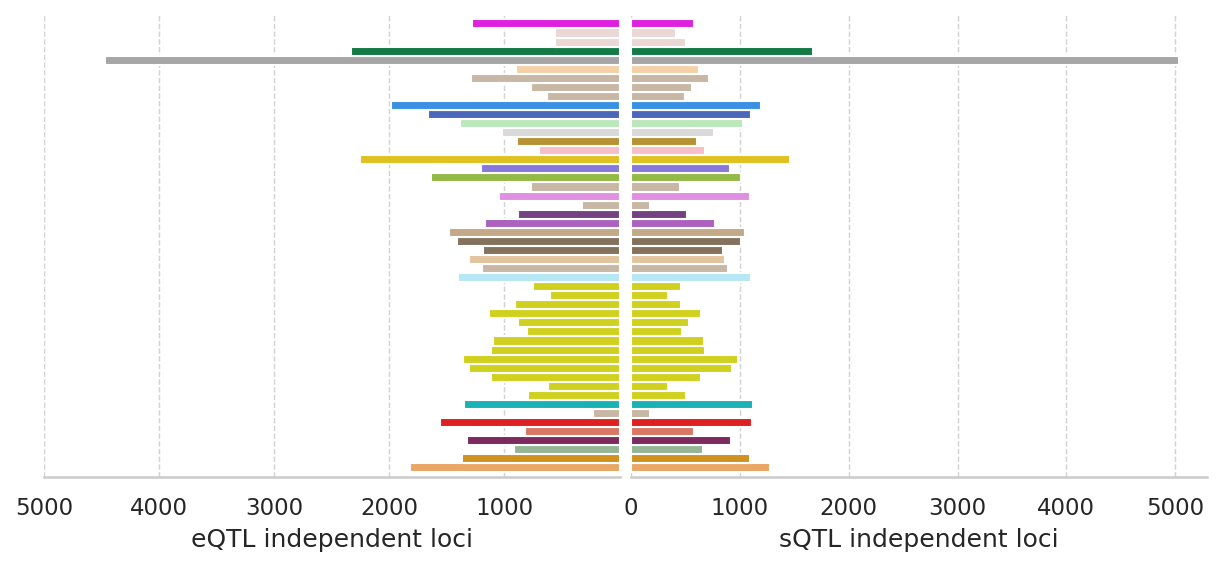

In [ ]:
# Barplots: tissue_abbrv (y-axis) vs number of independent loci (x-axis) for new_esusie (left, mirrored) and new_ssusie (right), with a black line at the top of each bar for number of 1-variant credible sets per tissue

# Map tissue_id to tissue_abbrv using tissue_df
tissue_id_to_abbrv = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_abbrv']))

# Count unique phenotype_id/cs_id combos per tissue_id for new_esusie
unique_counts_esusie = (
    new_esusie
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id'])
    .groupby('tissue_id')
    .size()
    .reset_index(name='independent loci')
)
unique_counts_esusie['tissue_abbrv'] = unique_counts_esusie['tissue_id'].map(tissue_id_to_abbrv)

# Count unique phenotype_id/cs_id combos per tissue_id for new_ssusie
unique_counts_ssusie = (
    new_ssusie
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id'])
    .groupby('tissue_id')
    .size()
    .reset_index(name='independent loci')
)
unique_counts_ssusie['tissue_abbrv'] = unique_counts_ssusie['tissue_id'].map(tissue_id_to_abbrv)

# Count number of 1-variant credible sets per tissue for new_esusie
esusie_cs_counts = (
    new_esusie
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'])
    .size()
    .reset_index(name='variant_count')
)
esusie_1cs = esusie_cs_counts[esusie_cs_counts['variant_count'] == 1]
esusie_1cs_counts = (
    esusie_1cs
    .groupby('tissue_id')
    .size()
    .reset_index(name='1-variant loci')
)
esusie_1cs_counts['tissue_abbrv'] = esusie_1cs_counts['tissue_id'].map(tissue_id_to_abbrv)

# Count number of 1-variant credible sets per tissue for new_ssusie
ssusie_cs_counts = (
    new_ssusie
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'])
    .size()
    .reset_index(name='variant_count')
)
ssusie_1cs = ssusie_cs_counts[ssusie_cs_counts['variant_count'] == 1]
ssusie_1cs_counts = (
    ssusie_1cs
    .groupby('tissue_id')
    .size()
    .reset_index(name='1-variant loci')
)
ssusie_1cs_counts['tissue_abbrv'] = ssusie_1cs_counts['tissue_id'].map(tissue_id_to_abbrv)

# Merge for consistent y order
all_tissues = pd.DataFrame({'tissue_abbrv': sorted(set(unique_counts_esusie['tissue_abbrv']).union(set(unique_counts_ssusie['tissue_abbrv'])))})
unique_counts_esusie = all_tissues.merge(unique_counts_esusie, on='tissue_abbrv', how='left')
unique_counts_ssusie = all_tissues.merge(unique_counts_ssusie, on='tissue_abbrv', how='left')
esusie_1cs_counts = all_tissues.merge(esusie_1cs_counts, on='tissue_abbrv', how='left')
ssusie_1cs_counts = all_tissues.merge(ssusie_1cs_counts, on='tissue_abbrv', how='left')

# Set up the figure with 2 axes: left barplot and right barplot, no center label
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 4), dpi=150, sharey=True, gridspec_kw={'wspace': 0.02})
sns.set(style="whitegrid")

# Plot left (eQTL, mirrored)
sns.barplot(
    data=unique_counts_esusie,
    y='tissue_abbrv',
    x='independent loci',
    palette=tissue_color_map,
    hue='tissue_id',
    legend=False,
    ax=ax_left,
    dodge=False,
    width=1
)

# # Overlay a black line as a vertical line for 1-variant loci
# for idx, row in esusie_1cs_counts.iterrows():
#     y = row['tissue_abbrv']
#     x = row['1-variant loci']
#     if pd.notnull(x):
#         y_pos = list(all_tissues['tissue_abbrv']).index(y)
#         ax_left.vlines(
#             x=x, ymin=y_pos - 0.4, ymax=y_pos + 0.4, color='black', linewidth=2, zorder=10
#         )

ax_left.invert_xaxis()
ax_left.set_ylabel('')
ax_left.yaxis.set_ticks_position('none')
ax_left.set_xlabel('eQTL independent loci')
ax_left.spines['top'].set_visible(False)
ax_left.spines['right'].set_visible(False)
ax_left.spines['left'].set_visible(False)
ax_left.spines['bottom'].set_visible(True)
ax_left.grid(axis='x', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax_left.grid(axis='y', visible=False)
ax_left.tick_params(axis='y', left=False, labelleft=False)

# Remove zero from x-axis ticks on the left plot
x_ticks = ax_left.get_xticks()
x_ticks_nozero = [tick for tick in x_ticks if tick != 0]
ax_left.set_xticks(x_ticks_nozero)

# Plot right (sQTL)
sns.barplot(
    data=unique_counts_ssusie,
    y='tissue_abbrv',
    x='independent loci',
    palette=tissue_color_map,
    hue='tissue_id',
    legend=False,
    ax=ax_right,
    dodge=False,
    width=1
)

# # Overlay a black line as a vertical line for 1-variant loci
# for idx, row in ssusie_1cs_counts.iterrows():
#     y = row['tissue_abbrv']
#     x = row['1-variant loci']
#     if pd.notnull(x):
#         y_pos = list(all_tissues['tissue_abbrv']).index(y)
#         ax_right.vlines(
#             x=x, ymin=y_pos - 0.4, ymax=y_pos + 0.4, color='black', linewidth=2, zorder=10
#         )

ax_right.yaxis.set_ticks_position('none')
ax_right.set_ylabel('')
ax_right.set_xlabel('sQTL independent loci')
ax_right.spines['top'].set_visible(False)
ax_right.spines['right'].set_visible(False)
ax_right.spines['left'].set_visible(False)
ax_right.spines['bottom'].set_visible(True)
ax_right.grid(axis='x', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax_right.grid(axis='y', visible=False)
ax_right.tick_params(axis='y', left=False, labelleft=False)
print(ax_right.get_ylim())
ax_right.set_ylim(-1, 50)
ax_left.set_ylim(-1, 50)
plt.show()

In [ ]:
unique_counts_esusie['independent loci'].median()

1125.5

In [ ]:
unique_counts_ssusie['independent loci'].median()

699.0

In [ ]:
# Count the number of unique 1-CS variants for new_esusie and new_ssusie

# For new_esusie
# Group by tissue_id, phenotype_id, cs_id and count number of variants per group
esusie_cs_counts = (
    new_esusie
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'])
    .size()
    .reset_index(name='variant_count')
)

# Filter to 1-CS groups (groups with only 1 variant)
esusie_1cs = esusie_cs_counts[esusie_cs_counts['variant_count'] == 1]

# Merge back to get the variant_id for these 1-CS groups
esusie_1cs_variants = pd.merge(
    esusie_1cs[['tissue_id', 'phenotype_id', 'cs_id']],
    new_esusie,
    on=['tissue_id', 'phenotype_id', 'cs_id'],
    how='left'
)

# Count unique variant_ids in the 1-CS set
num_unique_esusie_1cs_variants = esusie_1cs_variants['variant_id'].nunique()
print(f"Number of unique variants in 1-CS sets (new_esusie): {num_unique_esusie_1cs_variants}")

# For new_ssusie
ssusie_cs_counts = (
    new_ssusie
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'])
    .size()
    .reset_index(name='variant_count')
)
ssusie_1cs = ssusie_cs_counts[ssusie_cs_counts['variant_count'] == 1]
ssusie_1cs_variants = pd.merge(
    ssusie_1cs[['tissue_id', 'phenotype_id', 'cs_id']],
    new_ssusie,
    on=['tissue_id', 'phenotype_id', 'cs_id'],
    how='left'
)
num_unique_ssusie_1cs_variants = ssusie_1cs_variants['variant_id'].nunique()
print(f"Number of unique variants in 1-CS sets (new_ssusie): {num_unique_ssusie_1cs_variants}")


Number of unique variants in 1-CS sets (new_esusie): 4132
Number of unique variants in 1-CS sets (new_ssusie): 2080
